In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px 
import os
import matplotlib.ticker as mticker
import kagglehub
pd.set_option("display.max_columns", 100,
              "display.max_rows",None,
              "display.max_colwidth", None)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import plotly.graph_objects as go


/opt/anaconda3/envs/broadway/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


# Download latest version
path_broadway = kagglehub.dataset_download("mexwell/broadway-shows")

# print("Path to dataset files:", path_broadway)

In [3]:
broadway_file = os.path.join(path_broadway, "broadway.csv")
df_broadway = pd.read_csv(broadway_file)
df_broadway = df_broadway[df_broadway["Date.Year"]!=1990]

In [4]:
df_broadway.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31295 entries, 1 to 31295
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date.Day                    31295 non-null  int64 
 1   Date.Full                   31295 non-null  object
 2   Date.Month                  31295 non-null  int64 
 3   Date.Year                   31295 non-null  int64 
 4   Show.Name                   31295 non-null  object
 5   Show.Theatre                31295 non-null  object
 6   Show.Type                   31295 non-null  object
 7   Statistics.Attendance       31295 non-null  int64 
 8   Statistics.Capacity         31295 non-null  int64 
 9   Statistics.Gross            31295 non-null  int64 
 10  Statistics.Gross Potential  31295 non-null  int64 
 11  Statistics.Performances     31295 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 3.1+ MB


In [5]:
df_broadway["Date"] = pd.to_datetime(df_broadway["Date.Full"])
df_broadway["DateMonth"] = df_broadway["Date"].dt.to_period('M')
df_broadway["GrossMonthly"] = df_broadway.groupby("DateMonth")['Statistics.Gross'].transform('sum')


In [6]:
gross_monthly = df_broadway.groupby("DateMonth")['Statistics.Gross'].sum().reset_index()
gross_monthly.columns = ['DateMonth', 'GrossMonthly']
print(gross_monthly.head())

  DateMonth  GrossMonthly
0   1991-03        735071
1   1991-04       2709095
2   1991-05       3029947
3   1991-06       3865278
4   1991-07       3130141


In [7]:
gross_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype    
---  ------        --------------  -----    
 0   DateMonth     306 non-null    period[M]
 1   GrossMonthly  306 non-null    int64    
dtypes: int64(1), period[M](1)
memory usage: 4.9 KB


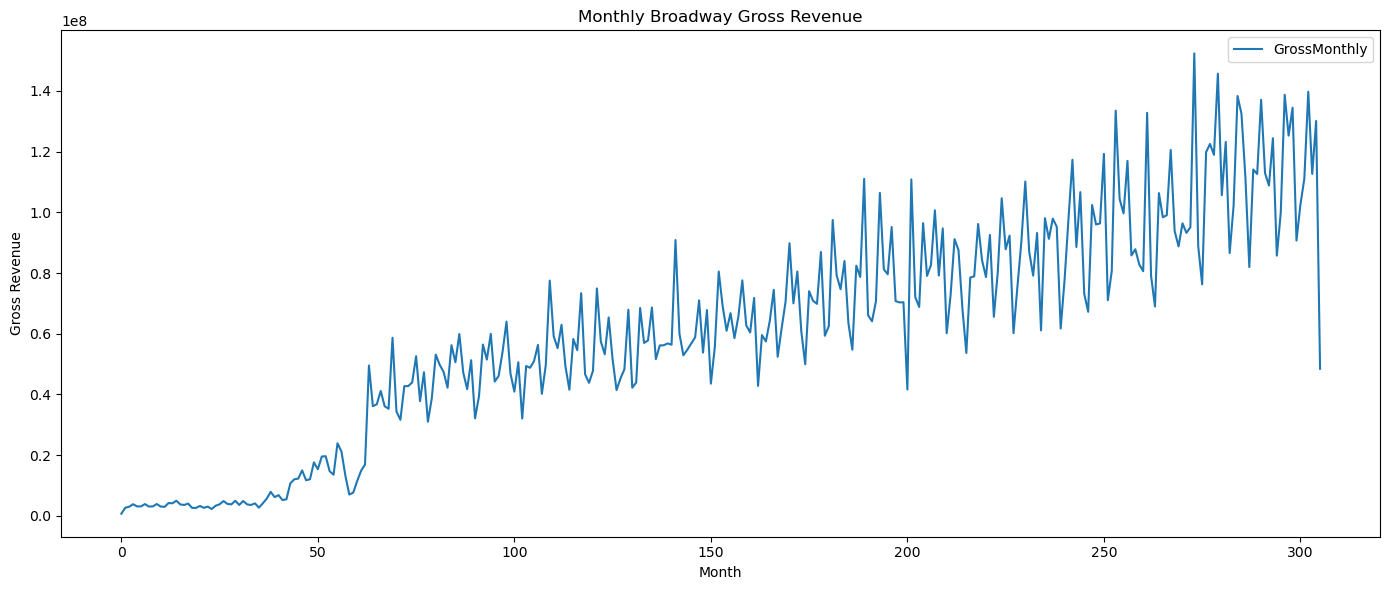

In [8]:
gross_monthly.plot(figsize=(14,6))
plt.title("Monthly Broadway Gross Revenue")
plt.xlabel("Month")
plt.ylabel("Gross Revenue")
plt.tight_layout()
plt.show()

In [9]:
import plotly.express as px
import pandas as pd

gross_monthly = df_broadway.groupby("DateMonth")['Statistics.Gross'].sum()
gross_monthly = gross_monthly.iloc[:-1]
gross_monthly.index = gross_monthly.index.to_timestamp()

# Create complete date range
date_range = pd.date_range(start=gross_monthly.index.min(), 
                           end=gross_monthly.index.max(), 
                           freq='MS')

# Reindex and fill missing values
gross_monthly = gross_monthly.reindex(date_range, fill_value=0)

gross_monthly_df = gross_monthly.reset_index()
gross_monthly_df.columns = ['DateMonth', 'GrossMonthly']

fig = px.line(gross_monthly_df, x='DateMonth', y='GrossMonthly',
              title='Monthly Broadway Gross Revenue',
              color_discrete_sequence=['darkturquoise'])

fig.update_traces(line=dict(width=3))
fig.update_layout(yaxis_tickformat='$,.0f', hovermode='x unified')
fig.show()

Simple Statistics

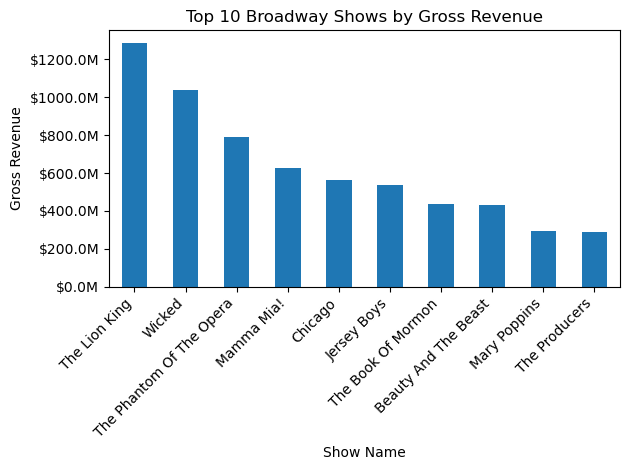

In [10]:
gross_by_show = df_broadway.groupby(["Show.Name"])['Statistics.Gross'].sum().reset_index()
gross_by_show.sort_values("Statistics.Gross", ascending=False).head(10).plot(
    x='Show.Name', 
    y='Statistics.Gross',
    kind='bar', 
    legend=False
)
plt.title("Top 10 Broadway Shows by Gross Revenue")
plt.xlabel("Show Name")
plt.ylabel("Gross Revenue")
plt.xticks(rotation=45, ha='right')
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))
plt.tight_layout()
plt.show()


In [11]:
gross_by_show[gross_by_show["Show.Name"] == 'Hamilton']

,Show.Name,Statistics.Gross
287,Hamilton,98459890


In [12]:
# TODO start with Prophet and then TBATS, agentic AI? 
# TODO Consider also deploying front-ends

In [13]:
gross_monthly = gross_monthly.iloc[:-1]
gross_monthly.tail()

2016-02-01     90701148
2016-03-01    102516741
2016-04-01    111121910
2016-05-01    139730711
2016-06-01    112649839
Freq: MS, Name: Statistics.Gross, dtype: int64

In [14]:
gross_monthly_df.head(15)

,DateMonth,GrossMonthly
0,1991-03-01,735071
1,1991-04-01,2709095
2,1991-05-01,3029947
3,1991-06-01,3865278
4,1991-07-01,3130141
5,1991-08-01,3134236
6,1991-09-01,3908432
7,1991-10-01,3101284
8,1991-11-01,3126045
9,1991-12-01,3926144


In [15]:
df_broadway["Date"].max()

Timestamp('2016-08-14 00:00:00')

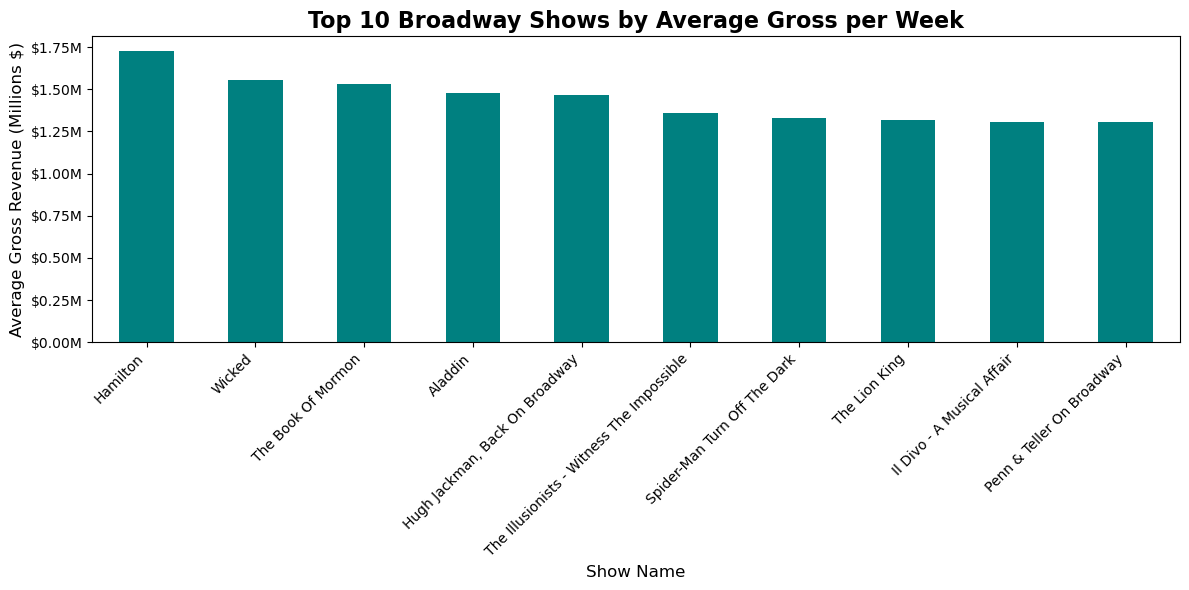

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Calculate average gross
avg_gross_by_show = df_broadway.groupby("Show.Name")['Statistics.Gross'].mean().sort_values(ascending=False)

# Plot top 10
plt.figure(figsize=(12, 6))
avg_gross_by_show.head(10).plot(kind='bar', color='teal')
plt.title("Top 10 Broadway Shows by Average Gross per Week", fontsize=16, fontweight='bold')
plt.xlabel("Show Name", fontsize=12)
plt.ylabel("Average Gross Revenue (Millions $)", fontsize=12)
plt.xticks(rotation=45, ha='right')

# Format y-axis in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'${x/1e6:.2f}M'))

plt.tight_layout()
plt.show()

In [17]:
gross_by_show = df_broadway.groupby(["Show.Name"])['Statistics.Gross'].sum().sort_values(ascending=False)
top_shows = gross_by_show.head(10)
y_col = 'Total Revenue'
title = f"Top {10} Broadway Shows by Total Revenue"
y_axis_title = "Total Revenue (Millions $)"
y_axis_tickformat = '$,.2s'
hovertemplate = '<b>%{x}</b><br>%{y_col}: $%{y:,.0f}<extra></extra>'

In [18]:
top_shows_df = top_shows.reset_index()
top_shows_df.columns = ['Show Name', y_col]

# Create Plotly bar chart
fig = go.Figure(data=[
    go.Bar(
        x=top_shows_df['Show Name'],
        y=top_shows_df[y_col],
        marker_color='teal',
        hovertemplate=hovertemplate
    )
])

fig.update_layout(
    title={
        'text': title,
        'font': {'size': 16, 'family': 'Arial, sans-serif'}
    },
    xaxis_title="Show Name",
    yaxis_title=y_axis_title,
    xaxis_tickangle=-45,
    height=600,
    hovermode='x',
    yaxis_tickformat=y_axis_tickformat)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'The Phantom Of The Opera'),
  Text(1, 0, 'Chicago'),
  Text(2, 0, 'The Lion King'),
  Text(3, 0, 'Mamma Mia!'),
  Text(4, 0, 'Beauty And The Beast'),
  Text(5, 0, 'Wicked'),
  Text(6, 0, 'Rent'),
  Text(7, 0, 'Jersey Boys'),
  Text(8, 0, 'Miss Saigon'),
  Text(9, 0, 'Les Miserables')])

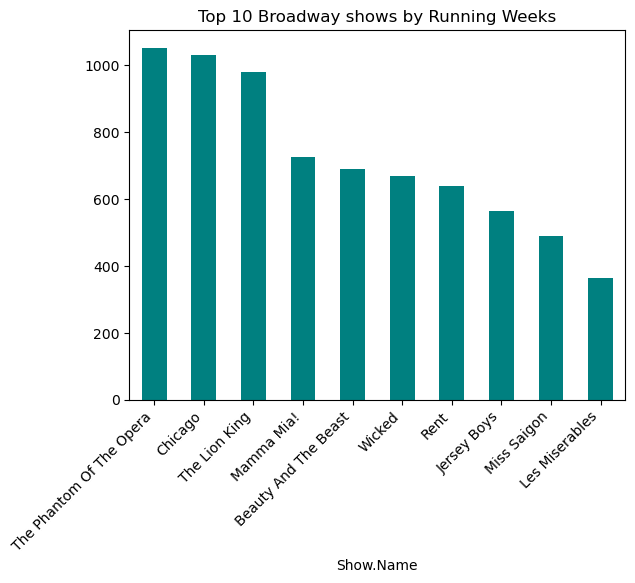

In [19]:
df_broadway["Show.Name"].value_counts().head(10).plot(kind = 'bar', color = 'teal')
plt.title("Top 10 Broadway shows by Running Weeks")
plt.xticks(rotation = 45, ha = 'right')

In [20]:
df_wicked  = df_broadway[df_broadway["Show.Name"]=="Wicked"]
len(df_wicked)

669

In [21]:
monthly_wicked = df_wicked.groupby("DateMonth")['Statistics.Gross'].sum()
monthly_wicked = monthly_wicked.iloc[:-1]
monthly_wicked.index = monthly_wicked.index.to_timestamp()

# Making sure we have no nulls
date_range = pd.date_range(start = monthly_wicked.index.min(),
                           end = monthly_wicked.index.max(),
                           freq = 'MS')

monthly_wicked = monthly_wicked.reindex(date_range, fill_value = 0)
monthly_wicked = monthly_wicked.reset_index()
monthly_wicked.columns = ["DateMonth", "GrossMonthly"]

def plot(df, y_col):
    fig = px.line(df, x= 'DateMonth', y=y_col, 
                title='Monthly Broadway Gross Revenue',
                color_discrete_sequence=['darkturquoise'])
    fig.update_traces(line = dict(width=3))
    fig.update_layout(yaxis_tickformat = '$,.0f', hovermode = 'x unified')
    fig.update_yaxes(rangemode = 'tozero')
    fig.show()

plot(monthly_wicked, "GrossMonthly")

In [22]:
monthly_wicked_train = monthly_wicked.loc

## SARIMA
Arima has components: Seasonality, Differencing and AR and MA Components.

### Stationarity
Firstly we will check for time series stationarity. A stationary time series has a constant mean and variance over time. 

In [23]:
def adf(series):
    test_results = adfuller(series)
    print('ADF Statistic:', test_results[0])
    print('P Value:', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

In [24]:
adf(monthly_wicked["GrossMonthly"])

ADF Statistic: -2.1970073002168116
P Value: 0.20733342676852884
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


We can clearly see the series is not stationary

In [25]:
monthly_wicked["GrossMonthlyDiff"] = monthly_wicked["GrossMonthly"].diff()
adf(monthly_wicked["GrossMonthlyDiff"][1:])

ADF Statistic: -7.002920514953333
P Value: 7.24395490665021e-10
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


In [26]:
plot(monthly_wicked, "GrossMonthlyDiff")

The Variance is also not constant, to make sure the variance is constant, We will use Box-cox transform.

In [27]:
monthly_wicked["GrossMonthlyBoxCox"] , lam = boxcox(monthly_wicked["GrossMonthly"])
lam

np.float64(0.818353817935012)

### A quick not on making variance constant:
1. Always make variance constant before differencing
2. lam = 0 , exponential
lam = 1 , no transform
lam = 2 , square root transform
lam = 3 , cubic transform

In [28]:
plot(monthly_wicked, "GrossMonthlyBoxCox")

In [29]:
adf(monthly_wicked["GrossMonthlyBoxCox"][1:])

ADF Statistic: -1.94101449755688
P Value: 0.3130192567755317
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


In [30]:
monthly_wicked["GrossMonthlyBoxCoxDiff"] = monthly_wicked["GrossMonthlyBoxCox"].diff()
plot(monthly_wicked, "GrossMonthlyBoxCoxDiff")


In [31]:
adf(monthly_wicked["GrossMonthlyBoxCoxDiff"][1:])

ADF Statistic: -6.982918440653841
P Value: 8.105081107076443e-10
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


### Decompositions

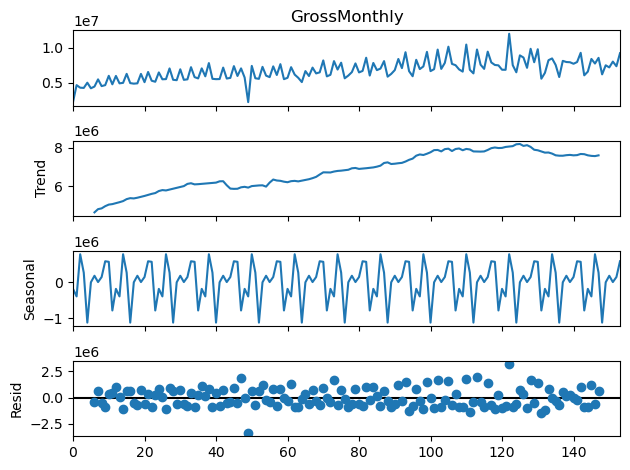

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition_plot_multi = seasonal_decompose(monthly_wicked['GrossMonthly'],
                                              model='additive',
                                              period = 12)
decomposition_plot_multi.plot()
plt.show()

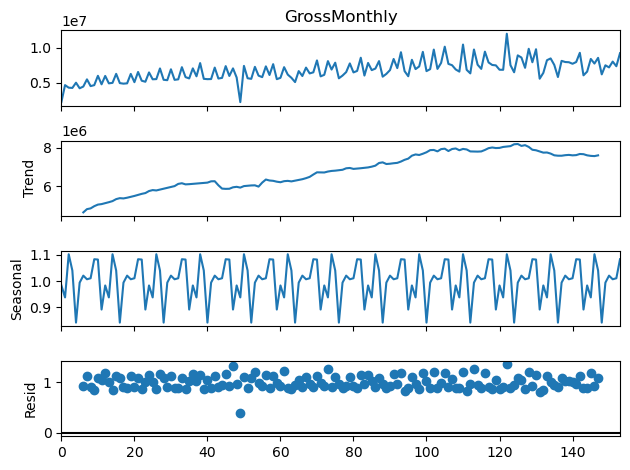

In [34]:
decomposition_plot_multi = seasonal_decompose(monthly_wicked['GrossMonthly'],
                                              model='multiplicative',
                                              period = 12)
decomposition_plot_multi.plot()
plt.show()

### ACF and PACF Plots

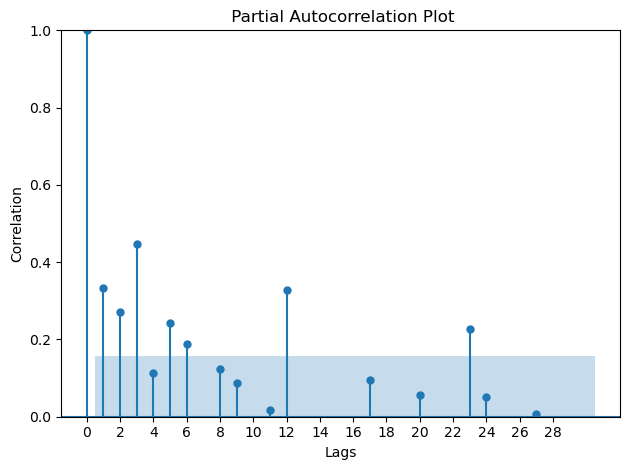

In [35]:
def pacf(df,col,lags):
    plot_pacf(df[col], lags = lags)
    plt.ylim(0,1)
    plt.xlabel('Lags')
    plt.xticks(ticks=np.arange(0,lags,2))
    plt.ylabel('Correlation')
    plt.title(' Partial Autocorrelation Plot')
    plt.tight_layout()
    plt.show()
pacf(monthly_wicked,col='GrossMonthly', lags=30)

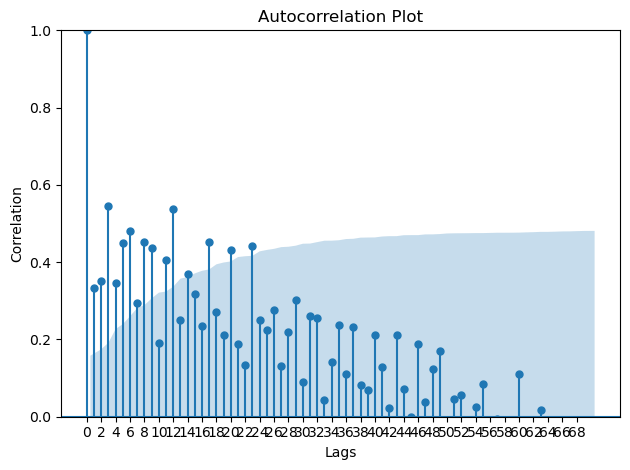

In [36]:
def acf(df,col,lags):
    plot_acf(df[col], lags = lags)
    plt.ylim(0,1)
    plt.xlabel('Lags')
    plt.xticks(ticks=np.arange(0,lags,2))
    plt.ylabel('Correlation')
    plt.title('Autocorrelation Plot')
    plt.tight_layout()
    plt.show()
acf(monthly_wicked,col = 'GrossMonthly',lags = 70)

In [37]:
def plot_func(df,df_test, forecast,col):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['DateMonth'] , y = df[col], name = 'Training Data'))
    fig.add_trace(go.Scatter(x = df_test['DateMonth'], y = df_test[col], name = 'Test Data'))
    fig.add_trace(go.Scatter(x = df_test['DateMonth'], y = forecast, name='Forecast'))
    fig.update_layout(hovermode = "x unified")
    #fig.update_layout(font=dict(size=18), title_text=title,
                     # title_x=0.5,  xaxis_title='Date',
                      #yaxis_title='Mean Ridership')
    return fig.show()

In [38]:
def error(df, col, forecast):
    mae = mean_absolute_error(df[col], forecast)
    print(mae)

In [39]:
split_idx = int(len(monthly_wicked) * 0.8)
train = monthly_wicked.iloc[:split_idx]
test = monthly_wicked.iloc[split_idx:]

In [40]:
p= 6
d = 1
q = 0
S = 12
model_sarima = ARIMA(train["GrossMonthlyBoxCox"], order=(6,1,20), seasonal_order=(0,0,0,12)).fit()
boxcox_forecasts = model_sarima.forecast(len(test))
forecast_sarima = inv_boxcox(boxcox_forecasts, lam)

/opt/anaconda3/envs/broadway/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/opt/anaconda3/envs/broadway/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [41]:
forecast_sarima

123    8.221179e+06
124    7.879618e+06
125    8.970607e+06
126    6.647323e+06
127    8.473196e+06
128    8.763876e+06
129    7.594889e+06
130    8.868282e+06
131    7.933688e+06
132    6.985598e+06
133    8.463418e+06
134    8.616457e+06
135    7.697508e+06
136    8.492929e+06
137    7.127985e+06
138    6.810152e+06
139    9.241750e+06
140    8.054059e+06
141    8.170364e+06
142    8.591142e+06
143    6.868853e+06
144    7.518044e+06
145    9.115866e+06
146    7.638130e+06
147    8.441418e+06
148    8.374271e+06
149    6.771116e+06
150    8.158949e+06
151    8.744062e+06
152    7.456792e+06
153    8.736234e+06
Name: predicted_mean, dtype: float64

In [42]:
res_df = pd.merge(test, forecast_sarima, left_index=True, right_index=True, how="right")

In [43]:
res_df = res_df[["DateMonth","predicted_mean"]]
res_df.to_csv("WickedResult.csv", index=False)

In [44]:
res_df.head()

,DateMonth,predicted_mean
123,2014-01-01,8.221179e+06
124,2014-02-01,7.879618e+06
125,2014-03-01,8.970607e+06
126,2014-04-01,6.647323e+06
127,2014-05-01,8.473196e+06


In [45]:
plot_func(train, test, forecast_sarima, "GrossMonthly")

In [46]:
error(test, "GrossMonthly", forecast_sarima)

863530.036795658


In [47]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [48]:
def model_eval(model):
    residual_df = train.copy()
    residual_df['fitted_values'] = model.fittedvalues
    residual_df["residuals"] = model.resid
    print(f'The mean of the residuals of {model} is {residual_df["residuals"].mean()}')
    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    plot_acf(residual_df['residuals'], lags = 60, ax = ax[0])
    ax[0].set_xlabel('Lags')
    plot_pacf(residual_df['residuals'], lags=60, ax=ax[1])
    ax[1].set_xlabel('Lags')
    plt.tight_layout()
    plt.show()
    print(f"Ljungbox Test: \n{acorr_ljungbox(residual_df['residuals'], return_df=True)}")
    print(f"Mean of residuals: {residual_df['residuals'].mean()}")

The mean of the residuals of <statsmodels.tsa.arima.model.ARIMAResultsWrapper object at 0x17bb05450> is 13601.021950078026


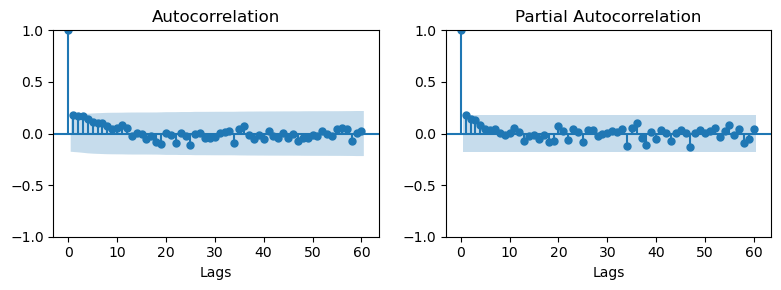

Ljungbox Test: 
      lb_stat  lb_pvalue
1    3.947985   0.046928
2    7.442213   0.024207
3   11.341675   0.010015
4   13.940785   0.007486
5   15.661486   0.007880
6   17.050369   0.009100
7   18.433171   0.010161
8   19.085092   0.014411
9   19.343668   0.022424
10  19.669557   0.032538
Mean of residuals: 13601.021950078026


In [49]:
model_eval(model_sarima)

## Prophet
Facebook Prophet is a simple but effective tool for time series prediction. The virtue of FB Prophet is that is easily explainable. The problem seems to be that FB Prophet was designed for livestreaming data on product usage for product like Facebook, Instagram, etc. In this example, I will just go through the basics. 